# Notebook M06 - Plume problem

This is an implementation of a 2D viscous flow code. The energy equation (for temperature) is solved at the cell centers (unlike the example in the chapter 10 notebook, which is solved at the basic nodes.

This notebook puts all of the major function definitions into separate source files and contains only the high-level program code.

In [9]:
# Import necessary packages
using SparseArrays
using LinearAlgebra
using IterativeSolvers
using WriteVTK
using Printf
using Statistics 
using Random
using NearestNeighbors
using DataFrames
using Printf
using CSV,DataFrames

include("Grid.jl")
include("GridOperations.jl")
include("Markers.jl")
include("Stokes.jl")
include("StokesCylindrical.jl")

include("Temperature.jl")
include("TemperatureCylindrical.jl")
include("melting/yasuda.jl")

# note that we import pyplot last to avoid a name conflict with grid.
using PyPlot
include("Visualization.jl")

plots (generic function with 1 method)

# Problem setup

- Lithosphere with initial geotherm set by plate cooling

In [2]:
# problem set-up
using SpecialFunctions
# function to define plate cooling solution
function plate_cooling(Tsurf,Tbtm,yL0,kappa,y,t)
   # y is a vector of y coordinates where we need the solution
    T = Tsurf .+ (Tbtm-Tsurf) .* (y/yL0)
    for n in 1:20 # note 20 is an index in a summation from 1 to Inf
        T += (Tbtm-Tsurf)*2/pi .* 1/n*exp(-kappa*n^2*pi^2*t/yL0^2)*sin(n*pi*y/yL0)
    end
    return T
end

function halfspace_cooling(Tsurf,Tmantle,kappa,y,t)
    if t == 0.0
        if y==0.0
            return Tsurf
        else
            return Tmantle
        end
    else
        T = Tsurf + (Tmantle-Tsurf)*erf(y/2/sqrt(kappa*t))         
        return T
    end
end

function halfspace_cooling_from_thickness(Tsurf,Tmantle,kappa,y,thickness)
    t = (thickness/2)^2/kappa
    return halfspace_cooling(Tsurf,Tmantle,kappa,y,t)
end

# function to compute solidus and liquidus

# function to compute melt fraction
function setup_steinberger_viscosity()
   filename = "data/visc.sh08"
   tmp = CSV.read(filename,DataFrame,comment="#");
   radius_nondimensional = tmp[:,1]
   depth_m = 6.371e6 .* (1.0 .- radius_nondimensional)
   viscosity = tmp[:,2]
   return linear_interpolation(reverse(depth_m),reverse(viscosity),extrapolation_bc=Line())
end

viscosity_depth_function = setup_steinberger_viscosity()

# function to compute viscosity
function viscosity(eta0::Float64,depth::Float64,T::Float64,E::Float64 ; visc_max=1.0e25)
   # E should be given in J/mol/K
   # Expect all temperatures in kelvin.
   Tref = 1350.0+273.0
   R = 8.314 #J/mol/K
   #depth_factor = depth > 6.6e5 ? 30.0 : 1.0
    depth_factor = viscosity_depth_function(depth)
   viscosity = depth_factor*exp(E/R/Tref*(Tref/T-1))
   if viscosity > visc_max
      viscosity = visc_max
   end
   return viscosity
end

struct Materials
    # 1 - ambient mantle
    # 2 - enhanced in eclogite
    alpha::Vector{Float64}
    rho0::Vector{Float64}
    Hr::Vector{Float64}
    Cp::Vector{Float64}
    kThermal::Vector{Float64}
    eta::Vector{Float64}
    Ea::Vector{Float64}
    function Materials()
         new([3e-5,3e-5],[3300.,3300.],[0.0,0.0],[1000.,1000.],[3.0,3.0],[1e21,1e21],[3e5,3e5])
    end
end

function update_melt!(markers::Markers,dt::Float64,mask::BitVector)
    # update the melt fraction on the markers.
    T = markers.scalarFields["T"]
    melt = markers.scalarFields["Xmelt"]
    dxdt = markers.scalarFields["dXdt"]
    
    Threads.@threads for i in 1:markers.nmark
        if mask[i]
            # note - melt fraction assumes celsius temperature:  
            new_melt = melt_fraction(melt_model,markers.x[2,i],adiabatic_temperature(markers.x[2,i],markers.scalars[T,i])-273.0)
            old_melt = markers.scalars[melt,i]
            markers.scalars[dxdt,i] = new_melt > old_melt ? (new_melt - old_melt)/dt : 0.0
            markers.scalars[melt,i] = new_melt
        end
    end
end

function update_melt!(markers::Markers,dt::Float64)
    mask = BitArray{1}(undef,markers.nmark)
    mask[:] .= true
    update_melt!(markers,dt,mask)
end


function update_marker_properties!(markers::Markers,materials::Materials)
    rho = markers.scalarFields["rho"]
    T = markers.scalarFields["T"]
    mmat = markers.integers[markers.integerFields["material"],:]
    eta = markers.scalarFields["eta"]
    
    Threads.@threads for i in 1:markers.nmark        
        # re-compute density using the current temperature value
        # assume reference temperature is 273.0
        # markers.scalars[rho,i] = materials.rho0[mmat[i]] # don't update density - for comparison with gerya
        markers.scalars[rho,i] = materials.rho0[mmat[i]]*(1.0-materials.alpha[mmat[i]]*(markers.scalars[T,i]-273.0)) 
        markers.scalars[eta,i] = viscosity(materials.eta[mmat[i]],markers.x[2,i],markers.scalars[T,i],materials.Ea[mmat[i]])
    end
end

function initial_conditions!(markers::Markers,materials::Materials,options::Dict)
    # Define geometric properties
    lithosphere_thickness = 1.5e5
    
    material = markers.integerFields["material"]
    T = markers.scalarFields["T"]
    eta = markers.scalarFields["eta"]
    alpha = markers.scalarFields["alpha"]
    cp = markers.scalarFields["Cp"]
    Hr = markers.scalarFields["Hr"]
    dxdt = markers.scalarFields["dXdt"]
    Threads.@threads for i in 1:markers.nmark
        mx = markers.x[1,i]
        my = markers.x[2,i]
        mr = ((mx-0)^2 + (my-1.2e6)^2)^0.5 
        
        #define initial cmb hot layer geometry
        h = 200e3 - (100e3)*(mx-0.0)/options["W"]
                
        #set material - eclogite at cmb
        if my > 2.85e6-h
           markers.integers[material,i] = 2
        else
           markers.integers[material,i] = 1
        end
        
        if my < lithosphere_thickness
            markers.scalars[T,i] = plate_cooling(273.0,1350.0+273.0,1.5e5,1e-6,my,100e6*3.15e7)
        else
            #markers.scalars[T,i] = 1350.0+273.0
            markers.scalars[T,i] = halfspace_cooling_from_thickness(options["Tcmb"],1350.0+273.0,1e-6,2.85e6-my,h)
        end
        #if mr <= 4e5
        #    markers.integers[material,i] = 2
        #    markers.scalars[T,i] += 200.0 # initial plume excess temperature
        #else
        #    markers.integers[material,i] = 1
        #end
                        
        ind = markers.integers[material,i]
        markers.scalars[eta,i] = viscosity(materials.eta[ind],markers.x[2,i],markers.scalars[T,i],materials.Ea[ind])
        markers.scalars[alpha,i] = materials.alpha[ind]            
        markers.scalars[cp,i] = materials.Cp[ind]  
        markers.scalars[Hr,i] = materials.Hr[ind]  
        markers.scalars[dxdt,i] = 0.0
    end
    update_marker_properties!(markers,materials)
end

initial_conditions! (generic function with 1 method)

In [3]:
# plotting routine
function plume_plots(grid::CartesianGrid,vx,vy,rho,T)
    # make some diagnostic plots using pyplot
    fig, (ax1,ax2,ax3,ax4) = subplots(1,4)
    ax1.pcolor(grid.xc,grid.yc,rho)
    ax1.invert_yaxis()
    ax1.set_title("Density")
    ax1.set_aspect("equal")
    ax2.pcolor(grid.xc,grid.yc,T)
    ax2.invert_yaxis()
    ax2.set_title("Temperature")
        ax2.set_aspect("equal")

    ax3.pcolor(grid.xc,grid.yc,vx)
    ax3.invert_yaxis()
    ax3.set_title("vx")
        ax3.set_aspect("equal")

    ax4.pcolor(grid.xc,grid.yc,vy)
    ax4.invert_yaxis()
    ax4.set_title("vy")
        ax4.set_aspect("equal")

    fig.show()
end


plume_plots (generic function with 1 method)

In [4]:
# Data and functions related to melting model
melt_model = yasuda()
# melt_model.pressure(5e5)
# melt_fraction(melt_model,3e5,1400.0)
melt_model.pressure(0.99e5)
function adiabatic_temperature(depth::Float64,T::Float64)
   # assume representative upper mantle adiabat of 0.4 K/km
   return T + 0.4/1000.0 * depth
end

function total_melt_rate(grid::CartesianGrid,dXdt::Matrix{Float64})
    total_melt = 0.0
     for j in 2:grid.nx
        for i in 2:grid.ny
            # 2 pi r dr dz
            total_melt += dXdt[i,j] > 0.0 ? 2.0*pi*grid.xc[j]*(grid.x[j]-grid.x[j-1])*(grid.y[i]-grid.y[i-1])*dXdt[i,j] : 0.0
        end
    end
    return total_melt
end

# function total_melt_rate_nodes(grid::CartesianGrid,Tnew::Matrix{Float64},Told::Matrix{Float64},dt::Float64)
#     total_melt = 0.0
#      for j in 2:grid.nx
#         for i in 2:grid.ny
#             # 2 pi r dr dz
#             # dXdt = Xnew[i,j] > Xold[i,j] ? (Xnew[i,j] - Xold[i,j])/dt : 0.0
#             Xnew = melt_fraction(melt_model,grid.yc[i],adiabatic_temperature(grid.yc[i],Tnew[i,j])-273.0)
#             Xlast = melt_fraction(melt_model,grid.yc[i],adiabatic_temperature(grid.yc[i],Tlast[i,j])-273.0)
#             total_melt += 2.0*pi*grid.xc[j]*(grid.x[j]-grid.x[j-1])*(grid.y[i]-grid.y[i-1])*dXdt
#         end
#     end
#     return total_melt
# end


function update_statistics(stats_file,step,time,total_melt)
    str = @sprintf("%d\t%e\t%e\n",step,time,total_melt);
    write(stats_file, str) 
    flush(stats_file)
end

update_statistics (generic function with 1 method)

# i2vis procedure

0. Set up the Eulerian grid and Lagrangian markers. Distribute the markers within the domain and assign initial conditions.
1. Compute density and viscosity at the basic nodes. Compute cell center viscosity via averaging.
2. Assemble and solve the Stokes equations.
3. Compute the maximum timestep from the velocity field and CFL number.
3. Transfer temperature from markers to basic nodes.
4. Compute the new temperature solution.
5. If the maximum temperature change exceeds a specified value, reduce the timstep and repeat previous step.
6. Compute the subgrid temperature changes and update the temperature on the markers.
7. Move the markers using 4th order Runge-Kutta

In [5]:
seconds_in_year = 3.15e7

options = Dict()
options["nx"] = 51
options["ny"] = 141
options["markx"] = 10
options["marky"] = 10
options["W"] = 1e6
options["H"] = 2.850e6
options["g"] = 10.0
options["Tcmb"] = 1350+500+273.0#2200.0+273.0
options["plot interval"] = 5e5*seconds_in_year
options["output directory"] = "plume_test_1950"

function plume_model(options::Dict;max_step::Int64=-1,max_time::Float64=-1.0)
    nx = options["nx"]#51#101
    ny = options["ny"]#141#285
    W = options["W"]
    H = options["H"]
    gx = 0.0
    gy = options["g"]

    #Tbcval = [0.0,0.0,273.0,1350.0+273.0]
    Tbcval = [0.0,0.0,273.0,options["Tcmb"]]
    bc = BoundaryConditions(0,0,0,0) # currently does nothing but is required argument to stokes solver.
    materials = Materials()
    melt_model = yasuda()
    markx = options["markx"]
    marky = options["marky"]
    target_markers = markx*marky
    min_markers = Int(floor(target_markers*0.75))
    max_markers = Int(ceil(target_markers*2.0))

    plot_interval = options["plot interval"] # plot interval in seconds
    end_time::Float64 = max_time == -1.0 ? typemax(Float64) : max_time
    max_step::Int64 = max_step == -1 ? typemax(Int64) : max_step
    
    dtmax = plot_interval
    grid = CartesianGrid(W,H,nx,ny)
    println("Creating Markers...")
    @time markers = Markers(grid,["alpha","Cp","T","rho","eta","Hr","Xmelt","dXdt"],["material"] ; nmx=markx,nmy=marky,random=true)
    println("Initial condition...")
    @time initial_conditions!(markers, materials, options)

    # define arrays for k, rho, cp, H at the basic nodes. Fill them with constant values for now.
    kThermal = 3.0 .*ones(grid.ny,grid.nx);

    time = 0.0
    iout=0
    last_plot = 0.0
    rho_c = nothing
    dt = 1e10

    local rho_c
    local rho_vx
    local rho_vy
    local alpha
    #       local Hr
    local Cp_c
    local eta_s
    local eta_n
    local eta_vx
    local eta_vy
    local vx,vy
    local vxc=nothing
    local vyc=nothing
    local T
    local dt
    local dTmax
    local dTemp
    local Tnew=nothing
    local Tlast
    local Xlast
    local Xnew
    local dXdt
    
    output_dir = options["output directory"]
    try
        mkdir(output_dir)
    catch
        println("output directory ",output_dir," already exists.")
    end
    
    itime=1
    stats_file = open(output_dir * "/statistics.txt","w")
    for key in keys(options)
        println(stats_file,"# ",key," => ",options[key])
    end
    flush(stats_file)
        
    local terminate = false
    while !terminate        
        update_marker_properties!(markers,materials)#itime==1 ? 0.0 : dt)
        # 1. Transfer properties markers -> nodes
        visc_method = "logarithmic"

        eta_s_new, = marker_to_stag(markers,grid,["eta",],"basic",method=visc_method);
        # 1b. Cell Centers
        rho_c_new,Cp_c_new,alpha_new,Tlast_new = marker_to_stag(markers,grid,["rho","Cp","alpha","T"],"center")
        eta_n_new, = marker_to_stag(markers,grid,["eta",],"center",method=visc_method);
        # 1c. Vx and Vy nodes:        
        eta_vx_new, = marker_to_stag(markers,grid,["eta"],"vx",method=visc_method)
        eta_vy_new, = marker_to_stag(markers,grid,["eta"],"vy",method=visc_method)
        rho_vx_new, = marker_to_stag(markers,grid,["rho",],"vx")
        rho_vy_new, = marker_to_stag(markers,grid,["rho",],"vy")
        
        # deal with any NaN values from interpolation:
        if itime > 1
            if any(isnan.(eta_s_new))
                println("found nan values")
            end
            replace_nan!(eta_s,eta_s_new)
            replace_nan!(rho_c,rho_c_new)
#             replace_nan!(Hr,Hr_new)
            replace_nan!(Cp_c,Cp_c_new)
            replace_nan!(alpha,alpha_new)
            replace_nan!(eta_n,eta_n_new)
            replace_nan!(Tlast,Tlast_new)
            # replace_nan!(Xlast,Xlast_new)            
            replace_nan!(rho_vx,rho_vx_new)
            replace_nan!(rho_vy,rho_vy_new)
            replace_nan!(eta_vx,eta_vx_new)
            replace_nan!(eta_vy,eta_vy_new)
        end
        # Copy field data 
        rho_vx = copy(rho_vx_new)
        rho_vy = copy(rho_vy_new)
        eta_vx = copy(eta_vx_new)
        eta_vy = copy(eta_vy_new)
        rho_c = copy(rho_c_new)
        #Hr = copy(Hr_new)
        Cp_c = copy(Cp_c_new)
        alpha = copy(alpha_new)
        eta_s = copy(eta_s_new)
        eta_n = copy(eta_n_new)
        Tlast = copy(Tlast_new)
        # Xlast = copy(Xlast_new)

        Tlast = ghost_temperature_center(grid,Tlast,Tbcval)
        
        # 2. Assemble and solve the stokes equations
        #L,R = form_stokes(grid,eta_s,eta_n,rho_vx,rho_vy,bc,gx,gy,dt=dt)
        L,R = form_stokes_cylindrical(grid,eta_s,eta_n,eta_vx,eta_vy,rho_vx,rho_vy,bc,gx,gy)
        stokes_solution = L\R
        vx,vy,P = unpack(stokes_solution,grid;ghost=true)
    
        # Get the velocity at the cell centers:
        vxc,vyc = velocity_to_centers(grid,vx,vy)
        adiabatic_heating = compute_adiabatic_heating(grid,rho_c,Tlast,alpha,gx,gy,vxc,vyc)
        shear_heating = compute_shear_heating(grid,vx,vy,eta_n,eta_s)
        H = (adiabatic_heating .+ shear_heating).*0.0
    
        # 3. Compute the advection timestep:
        if itime > 1
            # try to increase the timestep by 20% over the previous timestep.
            this_dtmax = min(1.2*dt,dtmax) 
        else
            this_dtmax = dtmax
        end
        dt = compute_timestep(grid,vxc,vyc ; dtmax=this_dtmax,cfl=0.25)
        
        dTmax = Inf
        dTemp = nothing
        Tnew = nothing
        titer=1
        for titer=1:2# limit maximum temperature change
            # assemble and solve the energy equation
            println("Trying with timestep ",dt/3.15e7/1e6," Myr")
            L,R = assemble_energy_equation_cylindrical(grid,rho_c,Cp_c,kThermal,H,Tlast,dt,Tbcval);
            Tnew = L\R;
            Tnew = reshape(Tnew,grid.ny,grid.nx);
            Tnew = ghost_temperature_center(grid,Tnew,Tbcval);

            T = copy(Tnew)

            dTemp = Tnew-Tlast
            # compute the maximum temperature change
            dTmax = maximum(abs.(dTemp[2:end-1,2:end-1]))
            println("dTmax=",dTmax," dt=",dt/3.15e7/1e6)
            dt = min(dt,dTmax < 10.0 ? dt : dt*10.0/dTmax)
            if dTmax < 10.0
                break
            end
        end
        if any(isnan.(markers.scalars[markers.scalarFields["rho"],:]))
            println("nan in density")
            break
        end
        dT_subgrid_node = subgrid_temperature_relaxation_center!(markers,grid,dTemp,Cp_c[1,1],kThermal[1,1],dt)
        dT_remaining = dTemp - dT_subgrid_node

        cell_center_change_to_markers!(markers,grid,dT_remaining,"T")
        
        # compute the melt fraction on the markers using the NEW temperature.
        if itime > 1            
            update_melt!(markers,dt) # compute melt on the markers (using new temperature)
            dXdt_new, = marker_to_stag(markers,grid,["dXdt",],"center")
            replace_nan!(dXdt,dXdt_new)
            dXdt = copy(dXdt_new)
            total_melt = total_melt_rate(grid,dXdt)
            println("total melt rate: ",total_melt)
        else
            total_melt = 0.0
            dXdt = zeros(grid.ny+1,grid.nx+1)
        end
        
        # Add/remove markers. When markers are added, give them temperature using the nodal temp.
        new_markers = add_remove_markers!(markers,grid,Tnew,min_markers,target_markers,max_markers);
        update_melt!(markers,dt,new_markers); # set the correct melt fraction on new markers.
                
        # Check Termination Criteria
        if time >= max_time || itime >= max_step
            terminate = true
        end
                
        # Visualization Output
        if time == 0.0 || time - last_plot >= plot_interval || terminate
            last_plot = time 
            # Eulerian grid output:
            name = @sprintf("%s/viz.%04d.vtr",output_dir,iout)
            println("Writing visualization fle ",name)
            vn = velocity_to_basic_nodes(grid,vxc,vyc)
            output_fields = Dict("rho"=>rho_c,"eta"=>eta_s,"velocity"=>vn,"pressure"=>P[2:end-1,2:end-1],"T"=>Tnew[2:end-1,2:end-1],"dXdt"=>dXdt[2:end-1,2:end-1])
            @time visualization(grid,output_fields,time/seconds_in_year;filename=name)
            # Markers output:
            name = @sprintf("%s/markers.%04d.vtp",output_dir,iout)
            println("Writing visualization fle ",name)
            visualization(markers,time/seconds_in_year;filename=name)
            
            iout += 1
        end
        update_statistics(stats_file,itime,time,total_melt)
        
        # Move the markers and advance to the next timestep
        println("Min/Max velocity: ",minimum(vyc)," ",maximum(vyc))
        move_markers_rk4!(markers,grid,vx,vy,dt,continuity_weight=1.0/3.0)
        time += dt
        itime += 1
        println("Finished Step ",itime," time=",time/seconds_in_year/1e6," Myr")
     end
     close(stats_file)
     return grid,markers,vx,vy,vxc,vyc,rho_c,dTemp,Tnew,Tlast,time
 end

plume_model (generic function with 1 method)

In [6]:
println("#",options)

#Dict{Any, Any}("nx" => 51, "g" => 10.0, "marky" => 10, "W" => 1.0e6, "plot interval" => 1.575e13, "output directory" => "plume_test_1950", "ny" => 141, "Tcmb" => 2123.0, "markx" => 10, "H" => 2.85e6)


In [8]:
# run the model.
#@time grid,markers,vx,vy,vxc,vyc,rho_c,dTemp,Tnew,Tlast,time = plume_model(options,max_time=200e6*3.15e7);
@time grid,markers,vx,vy,vxc,vyc,rho_c,dTemp,Tnew,Tlast,time = plume_model(options,max_time=300e6*3.15e7);
# divv = compute_velocity_divergence(grid,vx,vy)
# figure()
# pcolor(divv)
# colorbar()
# show()

Creating Markers...
  0.009301 seconds (22 allocations: 78.508 MiB)
Initial condition...
  0.436002 seconds (11.87 M allocations: 182.760 MiB, 37.64% gc time)
output directory plume_test_1950 already exists.
Trying with timestep 0.5 Myr
dTmax=2.965550409643015 dt=0.5
keeping 700000 markers nmark=700000
Writing visualization fle plume_test_1950/viz.0000.vtr
  0.018093 seconds (36.32 k allocations: 1.406 MiB)
Writing visualization fle plume_test_1950/markers.0000.vtp
  0.002296 seconds (2 allocations: 10.681 MiB)
Min/Max velocity: -5.153769687243539e-11 2.3238432059055495e-11
Finished Step 2 time=0.5 Myr
Trying with timestep 0.5 Myr
dTmax=3.251771545499878 dt=0.5
total melt rate: 42386.841697533106
keeping 700000 markers nmark=700000
Writing visualization fle plume_test_1950/viz.0001.vtr
  0.018759 seconds (36.32 k allocations: 1.406 MiB)
Writing visualization fle plume_test_1950/markers.0001.vtp
  0.002285 seconds (2 allocations: 10.681 MiB)
Min/Max velocity: -5.380433756144632e-11 2.36

LoadError: TaskFailedException

[91m    nested task error: [39mInterruptException:
    Stacktrace:
     [1] [0m[1mviscosity[22m[0m[1m([22m[90meta0[39m::[0mFloat64, [90mdepth[39m::[0mFloat64, [90mT[39m::[0mFloat64, [90mE[39m::[0mFloat64; [90mvisc_max[39m::[0mFloat64[0m[1m)[22m
    [90m   @ [39m[35mMain[39m [90m./[39m[90m[4mIn[2]:52[24m[39m
     [2] [0m[1mviscosity[22m
    [90m   @ [39m[90m./[39m[90m[4mIn[2]:46[24m[39m[90m [inlined][39m
     [3] [0m[1mmacro expansion[22m
    [90m   @ [39m[90m./[39m[90m[4mIn[2]:110[24m[39m[90m [inlined][39m
     [4] [0m[1m(::var"#370#threadsfor_fun#105"{var"#370#threadsfor_fun#104#106"{Markers, Materials, Int64, Vector{Int16}, Int64, Int64, UnitRange{Int64}}})[22m[0m[1m([22m[90mtid[39m::[0mInt64; [90monethread[39m::[0mBool[0m[1m)[22m
    [90m   @ [39m[35mMain[39m [90m./[39m[90m[4mthreadingconstructs.jl:84[24m[39m
     [5] [0m[1m#370#threadsfor_fun[22m
    [90m   @ [39m[90m./[39m[90m[4mthreadingconstructs.jl:51[24m[39m[90m [inlined][39m
     [6] [0m[1m(::Base.Threads.var"#1#2"{var"#370#threadsfor_fun#105"{var"#370#threadsfor_fun#104#106"{Markers, Materials, Int64, Vector{Int16}, Int64, Int64, UnitRange{Int64}}}, Int64})[22m[0m[1m([22m[0m[1m)[22m
    [90m   @ [39m[90mBase.Threads[39m [90m./[39m[90m[4mthreadingconstructs.jl:30[24m[39m

plume_test_1950/statistics.txt


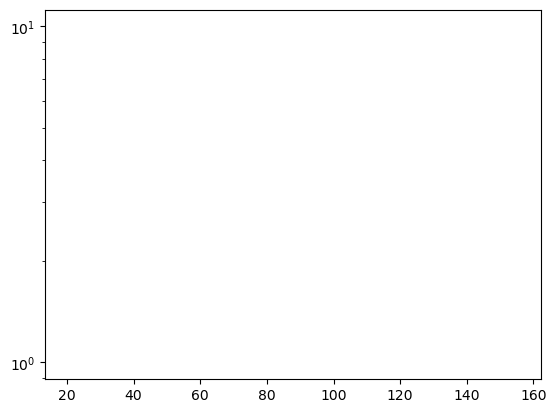

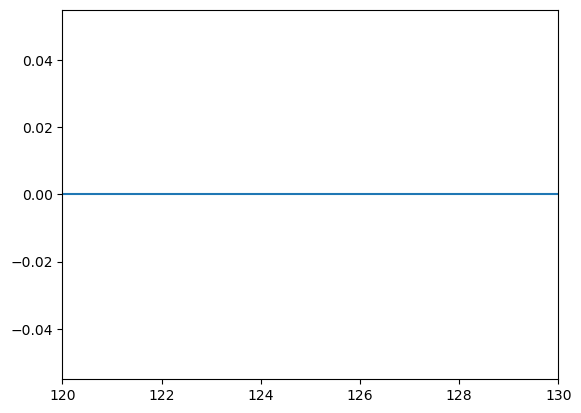

In [11]:
using CSV, DataFrames, FastRunningMedian
filename = options["output directory"]*"/statistics.txt"
println(filename)
melt_output = CSV.read(filename,DataFrame,comment="#");
time_out = melt_output[:,2]/3.15e7/1e6
mask = time_out .>= 20

# melt output is in units of m^3/s

melt_km3yr = melt_output[mask,3] .* (3.15e7/1e9)
melt_km3yr = running_median(melt_km3yr, 1)
figure()
plot(time_out[mask],melt_km3yr)
gca().set_yscale("log")
show()

n = length(melt_km3yr)
cumsum = zeros(n,1)

for i=2:n
    cumsum[i] = cumsum[i-1]+melt_km3yr[i]*(time_out[i]-time_out[i-1])
end
figure()
plot(time_out[mask],cumsum)
gca().set_xlim([120,130])
show()

In [9]:
figure()
scatter(markers.x[1,1:markers.nmark],markers.x[2,1:markers.nmark],c=isnan.(markers.scalars[markers.scalarFields["rho"],1:markers.nmark]),s=0.1,cmap="jet")
colorbar()
gca().invert_yaxis()
show()

ind = findall(isnan,(markers.scalars[markers.scalarFields["rho"],1:markers.nmark]))
print(ind)
markers.scalars[:,ind]

LoadError: UndefVarError: markers not defined

In [10]:
# figure()
# # title(print(time/3.15e7))
# # pcolor(grid.xc,grid.yc,eta_n)
# gca().invert_yaxis()
# colorbar()
# show()

figure()
scatter(markers.x[1,1:markers.nmark],markers.x[2,1:markers.nmark],c=(markers.integers[markers.integerFields["material"],1:markers.nmark]),s=0.1)
gca().invert_yaxis()
gca().set_aspect("equal")
colorbar()
show()

figure()
scatter(markers.x[1,1:markers.nmark],markers.x[2,1:markers.nmark],c=(markers.scalars[markers.scalarFields["rho"],1:markers.nmark]),s=0.1)
gca().invert_yaxis()
gca().set_aspect("equal")
colorbar()
show()


figure()
scatter(markers.x[1,1:markers.nmark],markers.x[2,1:markers.nmark],c=(markers.scalars[markers.scalarFields["T"],1:markers.nmark]),s=0.1)
gca().invert_yaxis()
gca().set_aspect("equal")
colorbar()
show()

LoadError: UndefVarError: markers not defined

In [11]:
# Optionally, run a few steps with the profiler
using ProfileSVG
@profview plume_model(2)

LoadError: MethodError: no method matching plume_model(::Int64)
[0mClosest candidates are:
[0m  plume_model([91m::Dict[39m; max_step, max_time) at In[5]:15

In [12]:
minimum(markers.scalars[markers.scalarFields["T"],:])

LoadError: UndefVarError: markers not defined

In [13]:
include("Markers.jl")
test = markers_per_cell(grid,markers)
figure()
pcolor(test)
colorbar()
show()

LoadError: UndefVarError: grid not defined

In [14]:

a=ones(Bool,10)
sum(a)
a[2] = false
sum(a)

9

In [ ]:
[10 .*ones(Int,1,10); ones(Int,1,10)] 

In [ ]:
rand(1,10)



In [ ]:
vn